# Export zip files

In [3]:
!unzip -o '/content/drive/MyDrive/Datasets/CMPE468/sign-dataset/TSRD-Test.zip' -d test
!unzip -o '/content/drive/MyDrive/Datasets/CMPE468/sign-dataset/tsrd-train.zip' -d train
print()

Görüntülenen çıkış son 5000 satıra kısaltıldı.
 extracting: test/028_0027_j.png     
 extracting: test/028_0028_j.png     
 extracting: test/028_0029_j.png     
 extracting: test/028_0030_j.png     
 extracting: test/028_0031_j.png     
 extracting: test/028_0032_j.png     
 extracting: test/028_0033_j.png     
 extracting: test/028_0034_j.png     
 extracting: test/029_0001_j.png     
 extracting: test/029_1_0001_1_j.png  
 extracting: test/029_1_0002_1_j.png  
 extracting: test/029_1_0003_1_j.png  
  inflating: test/029_1_0004_1_j.png  
 extracting: test/029_1_0005_1_j.png  
 extracting: test/029_1_0006_1_j.png  
 extracting: test/029_1_0007_1_j.png  
  inflating: test/029_1_0008_1_j.png  
  inflating: test/029_1_0009_1_j.png  
  inflating: test/029_1_0010_1_j.png  
  inflating: test/029_1_0011_1_j.png  
  inflating: test/029_1_0012_1_j.png  
  inflating: test/029_1_0013_1_j.png  
 extracting: test/029_0002_j.png     
 extracting: test/029_0003_j.png     
  inflating: test/029_0004_j

# Add libraries

In [4]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import models

# Dataset class

In [6]:
class ImageDataset(Dataset):

    def __init__(self, metadata, abs_path, transform=None):
        """Init function should not do any heavy lifting, but
            must initialize how many items are available in this data set.
        """
        self.metadata = metadata
        self.transform = transform
        self.abs_path = abs_path

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """
        image_path = self.metadata.loc[idx, 'file_name']
        image_label = self.metadata.loc[idx, 'OneHotLabel']
        image = Image.open(os.path.join(self.abs_path, image_path)).convert('RGB')

        image = self.transform(image)

        return image, image_label

# Util Logic to OneHotLabel

In [7]:
def logit_to_onehot(y_pred, nb_classes=6):
    """
    Creates one hot encoded matrix from 2D logit matrix.

    Example
    --------
    [[0.95, 0.045, 0.005]       --> [[1, 0, 0]]
     [0.10, 0.12, 0.78]]            [[0, 0, 1]]

    Parameters
    ----------
    y_pred: numpy.array or torch.Tensor
    nb_classes: int

    Returns
    -------
    one_hot: numpy.array
    """

    indices = np.argmax(y_pred, axis=1)
    one_hot = np.eye(nb_classes)[indices]

    return one_hot

# Fixed parameters


In [15]:
# define hyperparameters
learning_rate = 0.0001

# Batch size
bs = 64

old_loss = 100

# To select a GPU
device = torch.device('cuda')

# To clear CUDA memory
torch.cuda.empty_cache()

# Initialize the EfficientNet model
resnet34 = models.resnet34(weights='IMAGENET1K_V1')
resnet34.fc = torch.nn.Linear(in_features=512, out_features=6, bias=True)
model = resnet34.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Epoch size
num_epochs = 100

# Softmax
softmax = torch.nn.Softmax(dim=1)

# Previously selected classes

In [41]:
# Selected class 3 -> 40 Speed Sign - 318
# Selected class 16 -> No Car Sign - 218
# Selected class 17 -> No Horn Sign - 192
# Selected class 30 -> Bike Sign - 184
# Selected class 54 -> No Park Sign - 500
# Selected class 55 -> No Entrance Sign - 220

# Dataset Distribution 130 Train 15 Test 15 Validation due to minimum class that has selected.

tv_limit = 15
train_limit = 130

selected_classes = [3, 16, 17, 30, 54, 55]
selected_classes_text = ['40 Speed Sign', 'No Car Sign', 'No Horn Sign', 'Bike Sign', 'No Park Sign', 'No Entrance Sign']

# Create OneHotLabel

In [17]:
def change_to_onehot(label):
  if label == selected_classes[0]:
    return '[1, 0, 0, 0, 0, 0]'
  elif label == selected_classes[1]:
    return '[0, 1, 0, 0, 0, 0]'
  elif label == selected_classes[2]:
    return '[0, 0, 1, 0, 0, 0]'
  elif label == selected_classes[3]:
    return '[0, 0, 0, 1, 0, 0]'
  elif label == selected_classes[4]:
    return '[0, 0, 0, 0, 1, 0]'
  elif label == selected_classes[5]:
    return '[0, 0, 0, 0, 0, 1]'

# Transforms

In [18]:
input_size = 224  # 224x224x3

data_transforms = {
    'train': [
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ],
    'tv': [
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ],
}

# Create Datasets

## Dataset creation utilizing file paths

In [19]:
test_dataset_path = 'test'

test_locations = os.listdir(test_dataset_path)

test_df = pd.DataFrame(columns =['file_name', 'class_type', 'OneHotLabel'])

for selected_test in test_locations:
    class_number = int(selected_test.split('_')[0])
    if class_number in selected_classes:
      one_hot_label = change_to_onehot(class_number)
      row_to_append = pd.DataFrame([{'file_name': selected_test, 'class_type': class_number, 'OneHotLabel': one_hot_label}])
      test_df = pd.concat([test_df, row_to_append])

In [20]:
train_dataset_path = 'train'

train_locations = os.listdir(train_dataset_path)

train_df = pd.DataFrame(columns =['file_name', 'class_type', 'OneHotLabel'])

for selected_train in train_locations:
    class_number = int(selected_train.split('_')[0])
    if class_number in selected_classes:
      one_hot_label = change_to_onehot(class_number)
      row_to_append = pd.DataFrame([{'file_name': selected_train, 'class_type': class_number, 'OneHotLabel': one_hot_label}])
      train_df = pd.concat([train_df, row_to_append])

# Train Test and Validation Datasplits

In [21]:
train = pd.DataFrame()

# Split the DataFrame into two halves
for selected_class in selected_classes:

  train_selected = train_df[train_df.class_type == selected_class]
  train_limited = train_selected.iloc[:train_limit]
  train = pd.concat([train, train_limited])

In [22]:
train.groupby('OneHotLabel').agg('count')

,file_name,class_type
OneHotLabel,,
"[0, 0, 0, 0, 0, 1]",130,130
"[0, 0, 0, 0, 1, 0]",130,130
"[0, 0, 0, 1, 0, 0]",130,130
"[0, 0, 1, 0, 0, 0]",130,130
"[0, 1, 0, 0, 0, 0]",130,130
"[1, 0, 0, 0, 0, 0]",130,130


In [23]:
test = pd.DataFrame()
val = pd.DataFrame()

# Split the DataFrame into two halves
for selected_class in selected_classes:

  test_selected = test_df[test_df.class_type == selected_class]

  test_limited = test_selected.iloc[:tv_limit]
  val_limited = test_selected.iloc[tv_limit:tv_limit*2]

  test = pd.concat([test, test_limited])
  val = pd.concat([val, val_limited])

In [24]:
train = train.reset_index()
test = test.reset_index()
val = val.reset_index()

### Additional Tests

In [25]:
# To check all file_name's unique in test and validation datasets
for _, row_test in test.iterrows():
    file_name = row_test.file_name

    matches_val = val[val.file_name == file_name]

    if len(matches_val) > 0:
        assert False

for _, row_val in val.iterrows():
    file_name = row_val.file_name

    matches_test = test[test.file_name == file_name]

    if len(matches_test) > 0:
        assert False

# Apply Transforms - Prepare Datasets

In [26]:
# Define transformations (if any)
transform_train = transforms.Compose(data_transforms['train'])
transform_tv = transforms.Compose(data_transforms['tv'])

# Instantiate the dataset
train_dataset = ImageDataset(metadata=train, abs_path='train', transform=transform_train)

# Use DataLoader to access individual samples
train_data_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

# Instantiate the dataset
test_dataset = ImageDataset(metadata=test, abs_path='test', transform=transform_tv)

# Use DataLoader to access individual samples
test_data_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

# Instantiate the dataset
val_dataset = ImageDataset(metadata=val, abs_path='test', transform=transform_tv)

# Use DataLoader to access individual samples
val_data_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)

# Training

In [27]:
for epoch in range(num_epochs):
    print(epoch+1)
    train_loss = []
    dice_train = []
    model.train()

    for batch_index_train, batch_train in enumerate(train_data_loader):
      image, image_label = batch_train
      image_label = [eval(inner_list_str) for inner_list_str in list(image_label)]
      image_label = torch.tensor(image_label, dtype=torch.float32).to(device)

      image = image.to(device)
      outputs = model(image)
      outputs = softmax(outputs)

      loss = criterion(outputs, image_label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    with torch.no_grad():
      model.eval()
      for batch_index_val, batch_val in enumerate(val_data_loader):
        image, image_label = batch_val
        image_label = [eval(inner_list_str) for inner_list_str in list(image_label)]
        image_label = torch.tensor(image_label, dtype=torch.float32).to(device)

        image = image.to(device)
        outputs = model(image)
        outputs = softmax(outputs)
        loss = criterion(outputs, image_label)

      if loss < old_loss:
        old_loss = loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Datasets/CMPE468/resnet34.pth')
        print(loss.item())

1
1.2275285720825195
2
1.0906871557235718
3
1.060408592224121
4
5
6
1.056253433227539
7
8
9
10
11
12
13
14
15
16
17
18
1.0554488897323608
19
20
21
22
1.0507646799087524
23
24
25
1.0463695526123047
26
27
28
29
30
31
32
33
34
1.0452486276626587
35
36
37
38
39
40
1.0446176528930664
41
42
43
44
1.0444949865341187
45
46
47
1.044062614440918
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
1.043872594833374
65
66
67
68
69
70
71
72
73
74
75
76
1.0437920093536377
77
78
79
80
81
1.0437897443771362
82
83
84
85
86
1.0436519384384155
87
88
1.0436328649520874
89
90
91
92
93
94
95
96
97
98
99
100


# Testing

In [31]:
# To clear CUDA memory
torch.cuda.empty_cache()

test_resnet34 = models.resnet34(weights=None)
test_resnet34.fc = torch.nn.Linear(in_features=512, out_features=6, bias=True)
test_model = test_resnet34.to(device)
test_model.load_state_dict(torch.load('/content/drive/MyDrive/Datasets/CMPE468/resnet34.pth'))

<All keys matched successfully>

In [32]:
test_model.eval()

total = len(test)
correctly_predicted = 0

with torch.no_grad():
  for batch_index_test, batch_test in enumerate(test_data_loader):
      image, image_label = batch_test
      image_label = [eval(inner_list_str) for inner_list_str in list(image_label)]
      image_label = torch.tensor(image_label, dtype=torch.float32).to(device)

      image = image.to(device)
      outputs = test_model(image)
      outputs = softmax(outputs)
      loss = criterion(outputs, image_label)

      index_predicted = torch.argmax(outputs, dim=1, keepdim=True).to('cpu').numpy()

      # print(index_predicted, image_label)

      for index, label in enumerate(image_label):
        label = label.to('cpu').numpy()
        if label[index_predicted[index]] == 1:
          correctly_predicted += 1

      # print(index_predicted, image_label)

print((correctly_predicted / total) * 100, loss)

100.0 tensor(1.0436, device='cuda:0')


# External Validation Dataset

In [33]:
external_validation_pth = '/content/drive/MyDrive/Datasets/CMPE468/sign-dataset-external-validation/'

# Read external validation dataset
external_val = pd.read_excel(os.path.join(external_validation_pth, 'external_validation_set.xlsx'))

external_val['OneHotLabel'] = external_val.apply(lambda x: change_to_onehot(x['class']), axis=1)

In [34]:
transform_tv = transforms.Compose(data_transforms['tv'])

# Batch size
bs = 128

# Instantiate the dataset
external_val_dataset = ImageDataset(metadata=external_val, abs_path=os.path.join(external_validation_pth, 'images'), transform=transform_tv)

# Use DataLoader to access individual samples
external_val_loader = DataLoader(external_val_dataset, batch_size=bs, shuffle=True)

In [36]:
# To clear CUDA memory
torch.cuda.empty_cache()

test_resnet34 = models.resnet34(weights=None)
test_resnet34.fc = torch.nn.Linear(in_features=512, out_features=6, bias=True)
test_model = test_resnet34.to(device)
test_model.load_state_dict(torch.load('/content/drive/MyDrive/Datasets/CMPE468/resnet34.pth'))

<All keys matched successfully>

Accuracy: 0.9666666666666667 tensor(1.0833, device='cuda:0')


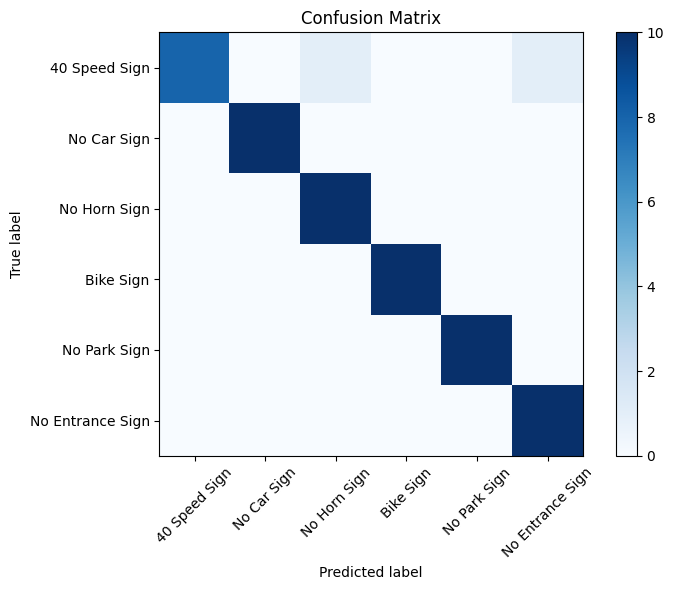

In [42]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []

    with torch.no_grad():
        for batch_index_external, batch_external in enumerate(data_loader):
            image, image_label = batch_external
            image_label = [eval(inner_list_str) for inner_list_str in list(image_label)]
            image_label = torch.tensor(image_label, dtype=torch.float32).to(device)

            image = image.to(device)
            outputs = model(image)
            outputs = softmax(outputs)
            loss = criterion(outputs, image_label)

            index_predicted = logit_to_onehot(outputs.cpu())

            _, predicted = torch.max(torch.tensor(index_predicted), 1)
            _, labels = torch.max(image_label.cpu(), 1)

            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print("Accuracy:", accuracy, loss)

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predicted)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(selected_classes_text))
    plt.xticks(tick_marks, selected_classes_text, rotation=45)
    plt.yticks(tick_marks, selected_classes_text)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# First evaluation
evaluate_model(test_model, external_val_loader)